# Training by using the derivative of multihead coherent state generation by pullback and a phase modulator

Use the multihead (2-head) gates in the phase space 
to create a network that represent a coherent state,
by starting from a Gaussian state and making a pullback

Use the derivative for the training


NOTE: remember to shut down the kernel when out of memory

<img src="../img/phasemodulator.png" width="900" height="200" />

<img src="../img/logo_circular.png" width="20" height="20" />@by claudio<br>

nonlinearxwaves@gmail.com<br>
@created 27 sep 2020<br>
@version 15 sep 2023

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages

In [2]:
import numpy as np
from thqml import phasespace as ps
from thqml.utilities import utilities
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float32

Precision for output on the screen

In [4]:
np.set_printoptions(precision=2)

## Dimension

In [5]:
N = 10

## Build vacuum by the Gaussian state

In [6]:
vacuum = ps.VacuumLayer(N)

## Build the pullback layer for generating the input coherent state

### Target displacement vector 
The displacement vector is a normalized column vector

In [7]:
dinput = 3.0*np.ones((N,1)); 
norm = np.linalg.norm(dinput)
dinput = dinput /norm
print(dinput.transpose())

[[0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32]]


Check the normalization of the dtarget

In [8]:
print(np.dot(dinput.transpose(), dinput)) 

[[1.]]


### Build the linear layer
The layer is a constant layer, as no training is needed

In [9]:
D = ps.DisplacementLayerConstant(dinput)

## Define the layer for the complex medium
The LinearConstantMultiHead generate by default a random medium with 
the relevant symplectic operator

In [10]:
R = ps.RandomLayerConstant(N)

## Define the trainable Phase Modulator layer

In [11]:
PM_train = ps.PhaseModulatorLayer(N)

### plot the matrix of the theta (initially random)

In [12]:
tf.print(tf.linalg.diag(PM_train.theta))

[[0.215320945 0 0 0 0]
 [0 0.163770884 0 0 0]
 [0 0 0.63708359 0 0]
 [0 0 0 0.0245276392 0]
 [0 0 0 0 0.361202389]]


### plot the symplectic matrix

In [13]:
M, _ ,_, _ = PM_train.get_M(); print(M)

tf.Tensor(
[[ 0.98 -0.21  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.21  0.98  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.99 -0.16  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.16  0.99  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.8  -0.59  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.59  0.8   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.   -0.02  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.02  1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.94 -0.35]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.35  0.94]], shape=(10, 10), dtype=float32)


## Define the normalized target displacement vector

In [14]:
dtarget = np.zeros((N,1)); dtarget[0]=1.0; dtarget[1]=0.5;
norm = np.linalg.norm(dtarget)
dtarget = dtarget /norm

## Connect the layers

In [15]:
xin = tf.keras.layers.Input(N);
x3, a3 = R(xin)
x2, a2 = PM_train(x3,a3)
x1, a1 = D(x2,a2)
chir, chii = vacuum(x1, a1) 
pullback = tf.keras.Model(inputs = xin, outputs=[chir, chii])
# Add the derivative layer
der_layer = ps.meanRLayer(N)
Re = der_layer(chir,chii, pullback)
pullback_der = tf.keras.Model(inputs = xin, outputs=Re)

### Store the M,d of the LL_complex layer for later chek

In [16]:
M_R_tf, _=R.get_M(); M_R=M_R_tf.numpy()

In [17]:
d_R=R.d.numpy()

### Store the M, d of the untrained U_train layer for later check

In [18]:
theta_untrained_PM = PM_train.theta.numpy()

## Build the training set by using a target characteristic function

Number of training points
Also a single training point is enough for Gaussian state, more points improve the training

In [19]:
Nbatch = 100

Define the numpy function for the target characteristic function:
    a coherent state with a target displacement
One need a target d for any training points

In [20]:
xtrain = np.random.rand(Nbatch, N)-0.5
dtrain = np.zeros((Nbatch,N))
for j in range(Nbatch):
    for i in range(N):
        dtrain[j,i]=dtarget[i]

## Train the model

In [21]:
pullback_der.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='mean_squared_error')

Summary of the derivative model

In [22]:
pullback_der.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 random_layer (RandomLayer)     [(None, 10),         50          ['input_1[0][0]']                
                                 (10, 1)]                                                         
                                                                                                  
 phase_modulator_layer (PhaseMo  [(None, 10),        5           ['random_layer[0][0]',           
 dulatorLayer)                   (10, 1)]                         'random_layer[0][1]']           
                                                                                            

Test the call of the derivative layer

In [23]:
pullback_der(xtrain)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.49, 0.11, 0.46, 0.22, 0.34, 0.23, 0.32, 0.13, 0.36, 0.27]],
      dtype=float32)>

## Training of the model

In [24]:
history = pullback_der.fit(x=xtrain,
                      y=dtrain,
                      epochs=100,
                      verbose=2)

Epoch 1/100
4/4 - 1s - loss: 0.1022 - 1s/epoch - 274ms/step
Epoch 2/100
4/4 - 0s - loss: 0.0979 - 7ms/epoch - 2ms/step
Epoch 3/100
4/4 - 0s - loss: 0.0938 - 9ms/epoch - 2ms/step
Epoch 4/100
4/4 - 0s - loss: 0.0899 - 7ms/epoch - 2ms/step
Epoch 5/100
4/4 - 0s - loss: 0.0860 - 9ms/epoch - 2ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0823 - 7ms/epoch - 2ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0787 - 9ms/epoch - 2ms/step
Epoch 8/100
4/4 - 0s - loss: 0.0752 - 9ms/epoch - 2ms/step
Epoch 9/100
4/4 - 0s - loss: 0.0718 - 8ms/epoch - 2ms/step
Epoch 10/100
4/4 - 0s - loss: 0.0684 - 9ms/epoch - 2ms/step
Epoch 11/100
4/4 - 0s - loss: 0.0652 - 8ms/epoch - 2ms/step
Epoch 12/100
4/4 - 0s - loss: 0.0620 - 10ms/epoch - 3ms/step
Epoch 13/100
4/4 - 0s - loss: 0.0590 - 11ms/epoch - 3ms/step
Epoch 14/100
4/4 - 0s - loss: 0.0560 - 8ms/epoch - 2ms/step
Epoch 15/100
4/4 - 0s - loss: 0.0532 - 11ms/epoch - 3ms/step
Epoch 16/100
4/4 - 0s - loss: 0.0504 - 10ms/epoch - 2ms/step
Epoch 17/100
4/4 - 0s - loss: 0.0478 - 8ms/e

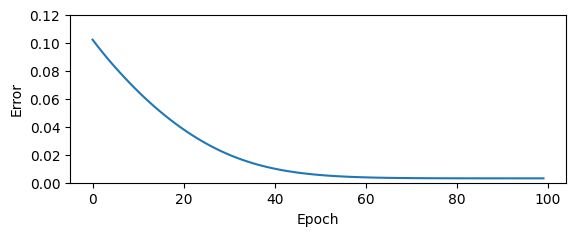

In [25]:
# %%
# %matplotlib inline
# Plot training & validation accuracy values
f1 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.ylim(0,0.12)
plt.savefig('training_PM.pdf', bbox_inches='tight')

## Test the derivative of the model
Evaluate the expectation value of the displacement as derivative of the characterisc function

In [26]:
x = tf.Variable(np.zeros((1,N)), dtype=tf_real) # the derivative are evaluated at x=0
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    chir, chii = pullback(x)

In [27]:
print(tape.gradient(chir,x))

tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)


In [28]:
print(tape.gradient(chii,x))

tf.Tensor([[ 0.88  0.44  0.07  0.05 -0.01 -0.1  -0.   -0.01  0.11  0.02]], shape=(1, 10), dtype=float32)


Use the derivative function for the derivative

Use the derivative model

In [29]:
pullback_der(xtrain)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.88,  0.44,  0.07,  0.05, -0.01, -0.1 , -0.  , -0.01,  0.11,
         0.02]], dtype=float32)>

## Plot the model

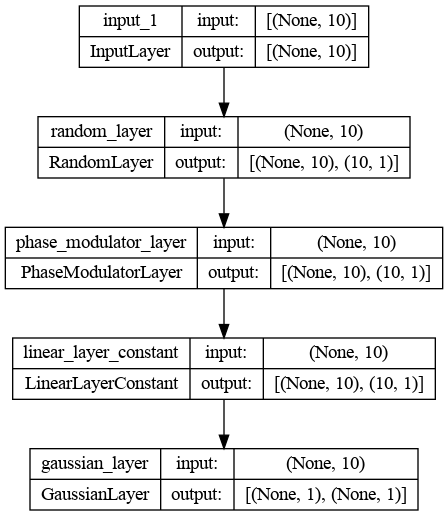

In [30]:
dot_img_file = 'PhaseModulator.png'
tf.keras.utils.plot_model(pullback, to_file=dot_img_file, show_shapes=True)

## Check the weights of the layers

### d and M of the complex layer LL_complex (these are unchanged)

In [31]:
print(R.d.numpy().transpose())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [32]:
print(d_R.transpose())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [33]:
M, _=R.get_M(); print(M.numpy())

[[ 0.46  0.17  0.29 -0.27 -0.52  0.08  0.28  0.39  0.24  0.19]
 [-0.17  0.46  0.27  0.29 -0.08 -0.52 -0.39  0.28 -0.19  0.24]
 [-0.51  0.24  0.31 -0.02  0.44  0.22  0.39  0.29  0.33  0.04]
 [-0.24 -0.51  0.02  0.31 -0.22  0.44 -0.29  0.39 -0.04  0.33]
 [ 0.4   0.06  0.54  0.19  0.31  0.37 -0.03 -0.04 -0.49 -0.17]
 [-0.06  0.4  -0.19  0.54 -0.37  0.31  0.04 -0.03  0.17 -0.49]
 [ 0.43 -0.13 -0.36  0.47  0.38 -0.25  0.3   0.36  0.1   0.1 ]
 [ 0.13  0.43 -0.47 -0.36  0.25  0.38 -0.36  0.3  -0.1   0.1 ]
 [ 0.23  0.15  0.11  0.22  0.14  0.18 -0.25 -0.5   0.51  0.49]
 [-0.15  0.23 -0.22  0.11 -0.18  0.14  0.5  -0.25 -0.49  0.51]]


In [34]:
print(M_R)

[[ 0.46  0.17  0.29 -0.27 -0.52  0.08  0.28  0.39  0.24  0.19]
 [-0.17  0.46  0.27  0.29 -0.08 -0.52 -0.39  0.28 -0.19  0.24]
 [-0.51  0.24  0.31 -0.02  0.44  0.22  0.39  0.29  0.33  0.04]
 [-0.24 -0.51  0.02  0.31 -0.22  0.44 -0.29  0.39 -0.04  0.33]
 [ 0.4   0.06  0.54  0.19  0.31  0.37 -0.03 -0.04 -0.49 -0.17]
 [-0.06  0.4  -0.19  0.54 -0.37  0.31  0.04 -0.03  0.17 -0.49]
 [ 0.43 -0.13 -0.36  0.47  0.38 -0.25  0.3   0.36  0.1   0.1 ]
 [ 0.13  0.43 -0.47 -0.36  0.25  0.38 -0.36  0.3  -0.1   0.1 ]
 [ 0.23  0.15  0.11  0.22  0.14  0.18 -0.25 -0.5   0.51  0.49]
 [-0.15  0.23 -0.22  0.11 -0.18  0.14  0.5  -0.25 -0.49  0.51]]


### d and M of the trained layer, before and after training (they must change)

In [35]:
PM_train.theta

<tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=array([ 0.03, -1.06,  2.67,  0.63,  0.35], dtype=float32)>

In [36]:
theta_untrained_PM

array([0.22, 0.16, 0.64, 0.02, 0.36], dtype=float32)

# Retrieve the covariance matrix (must be a unitary matrix)

In [37]:
print(ps.covariance(N)(chir, chii, pullback))

(<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[ 1.00e+00, -5.96e-08,  5.96e-08, -2.01e-07, -2.05e-08, -5.96e-08,
         1.81e-07, -1.86e-07, -1.64e-07, -1.64e-07],
       [-1.19e-07,  1.00e+00,  1.04e-07,  1.12e-07,  9.92e-08, -8.20e-08,
         1.19e-07,  6.89e-08,  9.69e-08, -5.59e-08],
       [ 2.98e-08,  1.19e-07,  1.00e+00,  8.85e-09, -1.40e-07,  3.54e-08,
        -1.07e-07, -2.91e-09, -2.05e-08,  1.44e-07],
       [-2.24e-07,  1.15e-07, -2.61e-08,  1.00e+00, -4.27e-08, -1.17e-07,
        -1.21e-08, -8.77e-08, -1.46e-07, -4.89e-09],
       [-2.05e-07,  6.98e-08, -9.50e-08, -3.27e-08,  1.00e+00, -4.54e-09,
         8.46e-08,  1.01e-07, -3.56e-08,  1.52e-07],
       [-8.94e-08, -8.20e-08,  3.45e-08, -8.38e-08,  1.40e-08,  1.00e+00,
        -7.81e-08,  9.27e-08, -1.02e-07, -4.66e-09],
       [ 1.17e-07,  1.45e-07, -4.67e-08,  5.97e-09,  1.25e-07, -4.14e-08,
         1.00e+00, -3.15e-08, -3.47e-08, -1.89e-07],
       [-1.25e-07,  5.45e-08,  5.47e-09, -5.13e-08,  5.41e-0